In [1]:
from algorithm_ranking import MeasurementsVisualizer, MeasurementsSimulator

### Get measurements

In [8]:
cfg = {}
cfg['alg1']  = [0.2,0.02] #[mean, std]
cfg['alg2']  = [0.2,0.01]
cfg['alg3']  = [0.2,0.01]
cfg['alg4']  = [0.18,0.01]
h0 = list(cfg.keys())
h0

['alg1', 'alg2', 'alg3', 'alg4']

In [9]:
#seed = 359
ms = MeasurementsSimulator(cfg, 'normal',seed=359) 
ms.measure(10,1)

In [10]:
#ms.get_alg_measurements()

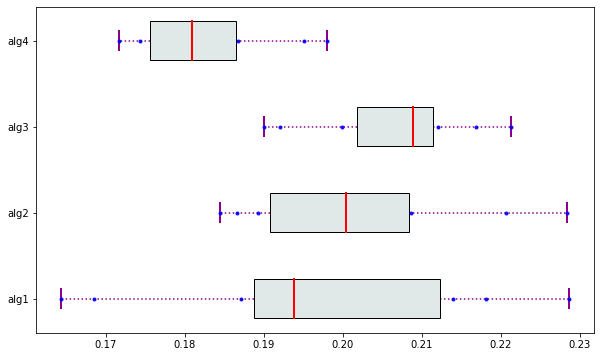

In [11]:
mv = MeasurementsVisualizer(ms.get_alg_measurements(), h0)
mv.show_measurements_boxplots()

### Alg Ranking: Sort

In [12]:
import random
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
from algorithm_ranking import CompareAlgs

class RankVariants(ABC):
    def __init__(self, alg_measurements, alg_seq_h0):
        self.measurements = alg_measurements
        self.alg_seq_h0 = alg_seq_h0
        self.compare_algs = CompareAlgs(alg_measurements,alg_seq_h0)

    
    @abstractmethod
    def rank_variants(self,q_max=75, q_min=25):
        pass


    def calculate_ranks(self, q_maxs=[95, 90, 85, 80, 75, 70, 65, 55],
                        q_mins=[5, 10, 15, 20, 25, 30, 35, 45]):
        #q_maxs = [95, 90, 85, 80, 75, 70, 65, 55]
        #q_mins = [5, 10, 15, 20, 25, 30, 35, 45]
        #q_maxs = [55, 55, 55, 55, 55]
        #q_mins = [5, 10, 20, 30, 40]
        #q_maxs = [75, 70, 65, 55]
        #q_mins = [25, 30, 35, 45]
        ranks = []
        for q_max, q_min in zip(q_maxs, q_mins):
            ranks.append(self.rank_variants(q_max, q_min).set_index('case:concept:name'))

        return pd.concat(ranks, axis=1)

    def calculate_roc(self):

        df_ranks = self.calculate_ranks()
        max_rank = df_ranks.max().max()
        if max_rank == 0:
            max_rank = 1
        x = df_ranks.apply(lambda x: x * (1. / len(df_ranks.columns))).sum(axis=1) / (max_rank)
        df_roc = pd.DataFrame(x)
        df_roc = df_roc.reset_index()
        df_roc = df_roc.rename(columns={0: 'case:roc'})

        df_roc.sort_values(by=['case:roc'], inplace=True)
        return df_ranks, df_roc

    def calculate_mean_rank(self, q_maxs=[95, 90, 85, 80, 75, 70, 65, 55],
                            q_mins=[5, 10, 15, 20, 25, 30, 35, 45] ):

        df_ranks = self.calculate_ranks(q_maxs, q_mins)

        x = df_ranks.sum(axis=1) / float(len(df_ranks.columns))
        df_mean = pd.DataFrame(x)
        df_mean = df_mean.reset_index()
        df_mean = df_mean.rename(columns={0: 'case:mean-rank'})

        df_mean.sort_values(by=['case:mean-rank'], inplace=True)
        return df_ranks, df_mean

In [20]:
class RankVariantsSort(RankVariants):
    def __init__(self, alg_measurements, alg_seq_h0):
        super().__init__(alg_measurements, alg_seq_h0)
        
    def rank_variants(self,q_max=75, q_min=25):
        self.compare_algs.init_comparision_matrix()

        p = len(self.alg_seq_h0)

        r = np.array([i for i in range(p)])
        s = np.array([i for i in range(p)])

        algs = {}
        for i in range(p):
            algs[s[i]] = self.alg_seq_h0[i]
            
        print(s+1)
        print(r)
        print("\n")

        for i in range(p):
            for j in range(0, p - i - 1):

                # ret = self.compareAlgs(algs[s[j]], algs[s[j+1]], threshold, M, K)
                ret = self.compare_algs.compare(algs[s[j]], algs[s[j + 1]], q_max, q_min)

                # if alg j+1 is faster than alg j
                if ret == 2:
                    # swap index
                    s[j], s[j + 1] = s[j + 1], s[j]

                    # update rank
                    if r[j + 1] == r[j]:
                        if self.compare_algs.comparision_matrix[algs[s[j+1]]][algs[s[j+2]]] != 1:
                            r[j + 1:] = r[j + 1:] + 1
                        else:
                            r[j + 1] = r[j + 1] + 1


                # alg j+1 is as good as alg j
                if ret == 1:
                    # update rank
                    if r[j + 1] != r[j]:
                        r[j + 1:] = r[j + 1:] - 1
                        
                    
                print("compare {} and {}".format(s[j]+1, s[j+1]+1))
                print(s+1)
                print(r)
                print("\n")

        columns = ['case:concept:name', 'case:rank:q{}-q{}'.format(int(q_max),int(q_min))]

        return pd.DataFrame([(algs[s[i]], r[i]) for i in range(p)], columns=columns)
    

In [21]:
rv = RankVariantsSort(ms.get_alg_measurements(), h0)
h0

['alg1', 'alg2', 'alg3', 'alg4']

In [22]:
ranks_25_75 = rv.rank_variants()

[1 2 3 4]
[0 1 2 3]


compare 1 and 2
[1 2 3 4]
[0 0 1 2]


compare 2 and 3
[1 2 3 4]
[0 0 0 1]


compare 4 and 3
[1 2 4 3]
[0 0 0 1]


compare 1 and 2
[1 2 4 3]
[0 0 0 1]


compare 4 and 2
[1 4 2 3]
[0 0 1 1]


compare 4 and 1
[4 1 2 3]
[0 1 1 1]




In [23]:
ranks_25_75

,case:concept:name,case:rank:q75-q25
0,alg4,0
1,alg1,1
2,alg2,1
3,alg3,1


In [24]:
ranks_25_75['case:concept:name'].tolist()

['alg4', 'alg1', 'alg2', 'alg3']

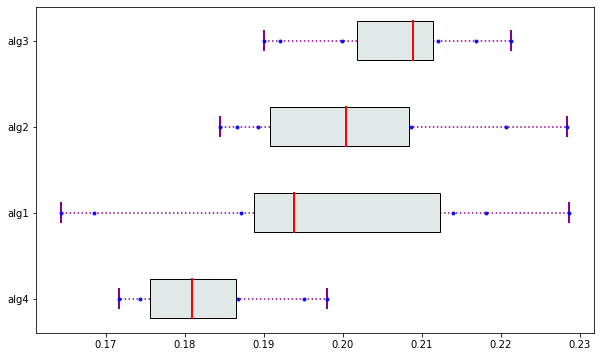

In [25]:
mv.show_measurements_boxplots(ranks_25_75['case:concept:name'].tolist())